In [1]:
import numpy as np
import os
import pandas as pd
import tables as tb
from glob import glob

import matplotlib.pyplot as plt
import invisible_cities.io.dst_io as dio

from matplotlib.patches import Patch

In [2]:
isotopes = ['214Bi', '208Tl']

In [3]:
isotope_factor = {'214Bi_sel':4.9 / 296, '214Bi_topo': 0.45 / 296, '208Tl_sel':5.2 / 1800, '208Tl_topo':0.47 / 1800}

In [4]:
info_list = []
info_isotope = []
for isotope in isotopes:
    path_full  = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/*/events_energy.h5'.format(isotope)
    path_gamma = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/*/events_energy_clean.h5'.format(isotope)
    st_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/event_stats.txt'.format(isotope)
    act_path = '/home/usc/ie/mpm/NEXT100-0nubb-analysis/nexus_job_templates/ft3/backgrounds/activities_efficiencies_upd.ods'
    #plot_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/plots/'.format(isotope)

    activities = dict(pd.read_excel(act_path, sheet_name=isotope, engine='odf').set_index("G4Volume").TotalActivity)
    activities['CENTER'] = None

    with open(st_path, 'r') as f:
        text = f.readlines()
        f.close()

    sim_evs = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*int(t.split(' ')[1]) for t in text}
    sim_evs['CENTER'] = int(1e6)

    #full_path = sorted([p for p in glob(path_full)])
    #gamma_path = sorted([p for p in glob(path_gamma)])

    bkg_full_path = sorted([p for p in glob(path_full) if p.split('/')[-2] != 'CENTER'])
    #act_full_path = sorted([p for p in glob(path_full) if p.split('/')[-2] == 'CENTER'])
    #bkg_gamma_path = sorted([p for p in glob(path_gamma) if p.split('/')[-2] != 'CENTER'])
    #act_gamma_path = sorted([p for p in glob(path_gamma) if p.split('/')[-2] == 'CENTER'])

    compute_range = False
    simulation_min_ener = 0.8
    min_counts_vol = 100

    #for activities in mBq to year^-1
    year = (3600 * 24 * 365) / 1000
    
    for f in bkg_full_path:
        vol = f.split('/')[-2]
        full_ev_ener = dio.load_dst(f, 'MC', 'EventEnergy')

        nrange = len(full_ev_ener)
        nroi = len(full_ev_ener[(full_ev_ener.energy >= 2.4) & (full_ev_ener.energy <= 2.5)])

        info_dict = {'isotope':isotope,
                     'vol':vol,
                     'act':activities[vol],
                     'nsim':sim_evs[vol], 
                     'exp':sim_evs[vol]/(activities[vol] * year),
                     'nrange':nrange, 
                     'nroi':nroi, 
                     'nroi_sel': nroi * isotope_factor[isotope + '_sel'], 
                     'nroi_topo': nroi * isotope_factor[isotope + '_topo']}

        #info_dict = {'vol':vol, 'nroi_topo':nroi * isotope_factor[isotope + '_topo']}
        
        info_list.append(info_dict)
    info_isotope.append(info_list)
info_df = pd.DataFrame(info_list)

In [5]:
info_df[info_df.isotope == '208Tl'].reset_index(drop=True).sum()

isotope      208Tl208Tl208Tl208Tl208Tl208Tl208Tl208Tl208Tl2...
vol          ANODE_RINGCATHODE_RINGDB_PLUGEP_COPPER_PLATEFI...
act                                                    3675.72
nsim                                                2167002174
exp                                                    409.435
nrange                                                 5838618
nroi                                                    124679
nroi_sel                                               360.184
nroi_topo                                              32.5551
dtype: object

In [6]:
variable = 'nroi_topo'
print_df = info_df[['isotope', 'vol', 'nsim', variable]]
print_Bi = print_df[print_df.isotope == '214Bi']
print_Bi = print_Bi.drop('isotope', axis = 1).rename(columns = {'nroi_topo':'214Bi\nTotal={:.1f}'.format(print_Bi.sum()[variable]),
                                                                'nsim':'214Bi sim evs\nExp=~40 years\nTotal={:.1e}'.format(print_Bi.sum()['nsim'])})
print_Tl = print_df[print_df.isotope == '208Tl']
print_Tl = print_Tl.drop('isotope', axis = 1).rename(columns = {'nroi_topo':'\n208Tl\n20 years\n' + 'Total={:.1f}\n'.format(print_Tl.sum()[variable])})
df = print_Bi.merge(print_Tl, on = ['vol']).set_index('vol')

In [11]:
print_Bi

,vol,214Bi sim evs\nExp=~40 years\nTotal=1.4e+10,214Bi\nTotal=23.3
0,ANODE_RING,6127152,0.326858
1,CATHODE_RING,5872545,0.570101
2,DB_PLUG,199920050,0.025845
3,EP_COPPER_PLATE,386100000,2.842905
4,FIELD_RING,40409712,3.978547
5,GATE_RING,6096272,0.421115
6,HDPE_TUBE,3938760,0.296453
7,ICS,236432040,2.725845
8,LIGHT_TUBE,2517076,0.688682
9,OPTICAL_PAD,10165771,0.670439


Text(0.5, 1.0, 'topological cut')

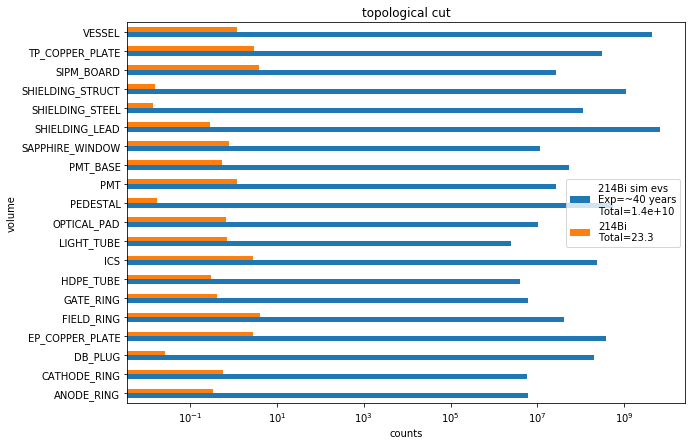

In [7]:
print_Bi.set_index('vol').plot.barh(figsize=(10, 7))
plt.xscale('log')
plt.xlabel('counts')
plt.ylabel('volume')
plt.title('topological cut')

Text(0.5, 1.0, 'topological cut')

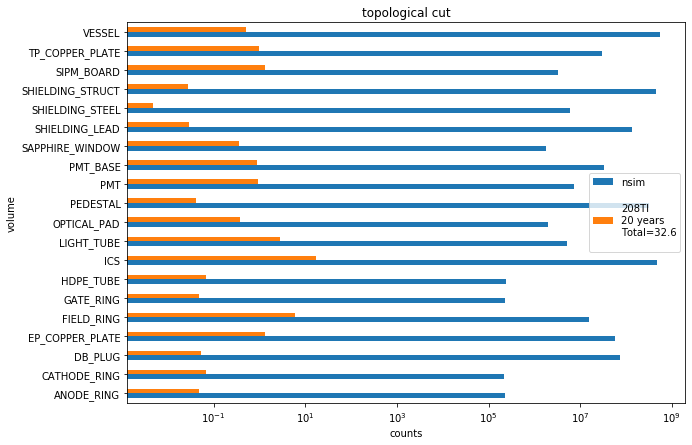

In [8]:
print_Tl.set_index('vol').plot.barh(figsize=(10, 7))
plt.xscale('log')
plt.xlabel('counts')
plt.ylabel('volume')
plt.title('topological cut')

Text(0.5, 1.0, 'topological cut')

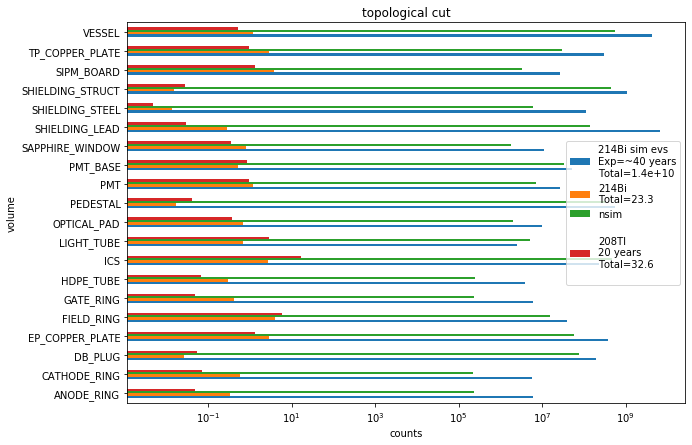

In [9]:
df.plot.barh(figsize=(10, 7))
plt.xscale('log')
plt.xlabel('counts')
plt.ylabel('volume')
plt.title('topological cut')